In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

# Simulation - Fully connected NN with Gaussian Kernel & External Input

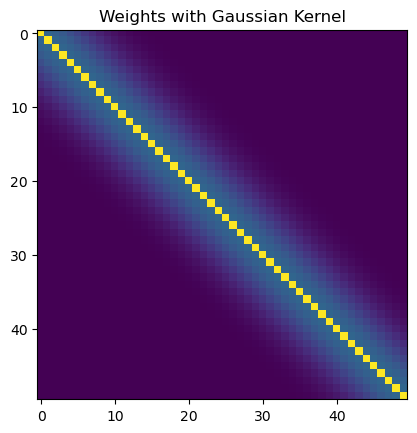

In [58]:
num_nodes = 50
num_time_steps = 20

w = np.zeros((num_nodes, num_nodes))
width = 0.2

for r in range(1, num_nodes + 1):
    for c in range(1, num_nodes + 1):
        w[r - 1][c - 1] = math.exp(-math.pow(r - c, 2) / 2 * math.pow(width, 2)) # TODO no two for loops :) -- linspace

np.fill_diagonal(w, 3)
plt.title("Weights with Gaussian Kernel")
plt.imshow(w)
# plt.plot(np.arange(num_nodes), w);

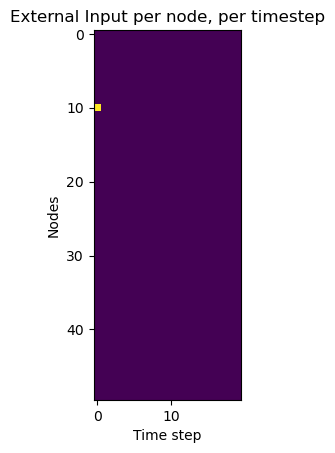

In [63]:
external_input = np.zeros((num_nodes, num_time_steps))
# external_input[5, 7] = 1
# external_input[10, 7] = 0.9
external_input[10, 0] = 1
# external_input[45, 7] = 0.8
# external_input[20:40, 0] = np.random.default_rng().random(20)
# external_input[20:40, 0] = np.ones(20)

def plot_external_input(external_input, t):
    plt.title('External Input per node, per timestep')
    plt.xlabel("Time step")
    plt.ylabel("Nodes")
    plt.imshow(external_input)
    # plt.plot(np.arange(1, t + 1), np.transpose(external_input));
plot_external_input(external_input, num_time_steps)

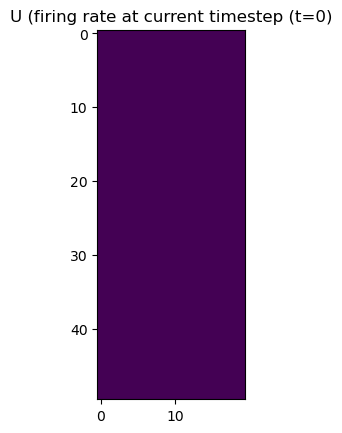

In [64]:
# activity rate per neuron for t timesteps
U = np.zeros((num_nodes, num_time_steps))
plt.title('U (firing rate at current timestep (t=0)')
plt.imshow(U)

In [65]:
tau = 1
mu = 2
def nn_ode(t, Uc, W, I, tau, mu):
    # Transpose W because our W[r,c] signifies the weight from neuron r to c
    # We want to add up the weighted connections to each neuron in Uc
    t = int(t)
    Uc[Uc < 0] = 0 # rectify Uc the negative part -- set negative Uc to be 0

    Oc = Uc**2 / (1 + mu * Uc.T.dot(Uc)) # global inhibition
    return (-Uc + W.T.dot(Oc) + I[:, t]) / tau

Oc = U[:, 0]
solution = sp.integrate.solve_ivp(nn_ode, [0, num_time_steps - 1], U[:, 0], t_eval=np.arange(0, num_time_steps), args=(w, external_input, tau, mu))
print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0  1 ... 18 19]
        y: [[ 0.000e+00  1.706e-02 ...  8.175e-02  8.135e-02]
            [ 0.000e+00  2.465e-02 ...  1.046e-01  1.041e-01]
            ...
            [ 0.000e+00  3.801e-11 ...  4.944e-08  5.027e-08]
            [ 0.000e+00  1.388e-11 ...  2.206e-08  2.245e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 110
     njev: 0
      nlu: 0


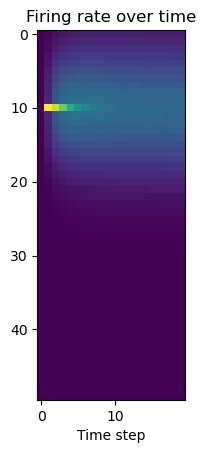

In [66]:
plt.title("Firing rate over time")
plt.xlabel("Time step")
plt.imshow(solution.y)
# plt.plot(solution.t, solution.y.T);

# Simulation - Periodic Stimulus
"To mimic real situations more precisely, such as when the stimulus is the orientation or moving direction of objects, we restrict the stimulus in the simulation to be a periodical variable. More exactly, we consider stimulus x (and so does the preferred stimulus of neurons) in the range (−π, π ], with x = θ and x = 2π + θ being the same. Under this condition, the steady states of the network will no longer have the exact gaussian form as in equation 2.4. However, provided that the value of a is not too large, say, a < π as considered here, the bell shape of steady states still holds, as confirmed by the simulation." (Wu & Amari 2005)

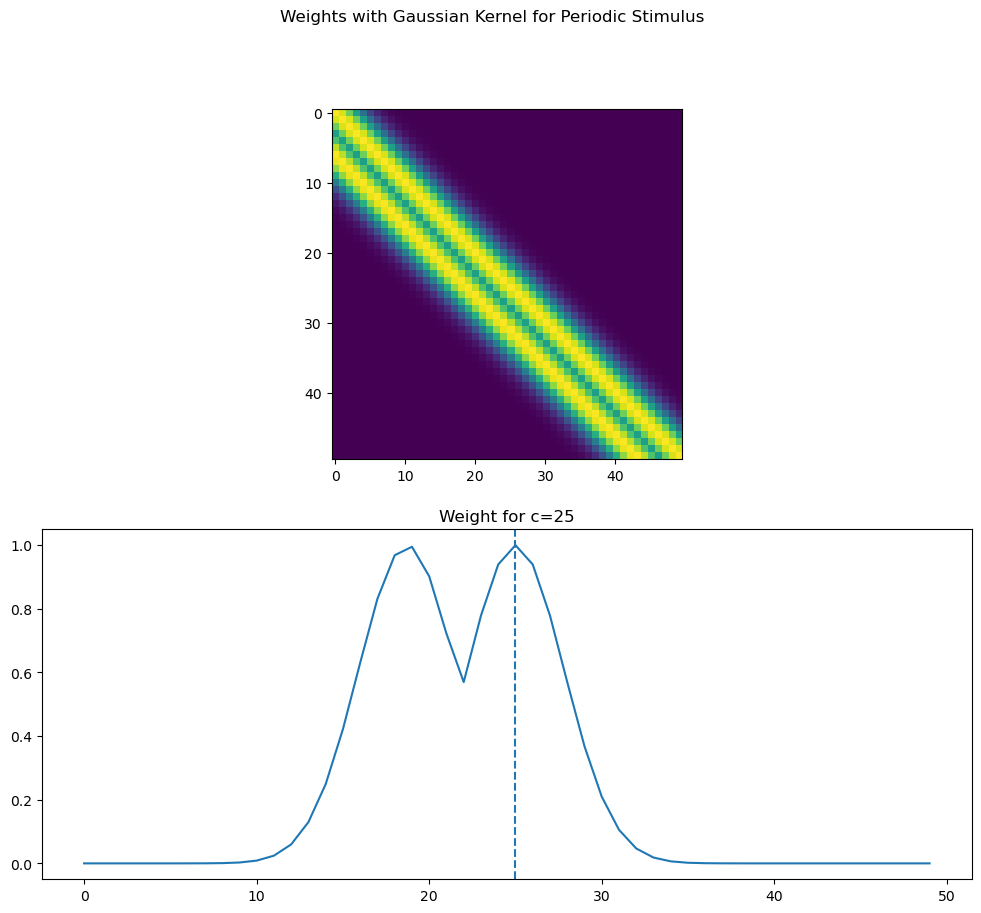

In [29]:
num_nodes = 50
num_time_steps = 20

w = np.zeros((num_nodes, num_nodes))
width = 2
for r in range(1, num_nodes + 1):
    for c in range(1, num_nodes + 1):
        if r - c <= math.pi:
            w[r - 1][c - 1] = math.exp(-math.pow(r - c, 2) / (2 * width * math.pow(width, 2)))
        else:
            w[r - 1][c - 1] = math.exp(-math.pow(2 * math.pi - math.fabs(r - c), 2) / (2 * width * math.pow(width, 2)))

plotted_weight_index = 25
fig, axs = plt.subplots(2, figsize=(12, 10))
fig.suptitle('Weights with Gaussian Kernel for Periodic Stimulus')
# axs[0].plot(np.arange(num_nodes), w)
axs[0].imshow(w)
axs[1].title.set_text('Weight for c=%d' % plotted_weight_index)
axs[1].plot(np.arange(num_nodes), w[plotted_weight_index])
axs[1].axvline(plotted_weight_index, linestyle='--')
plt.show();

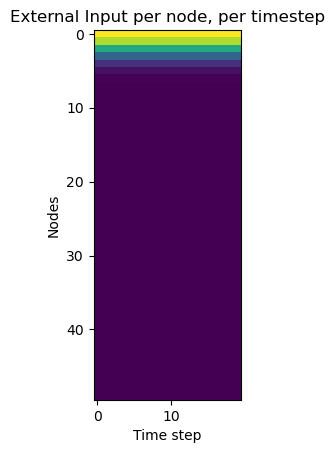

In [52]:
def get_input_with_bump(neurons_to_bump: list, timestep_of_bump, N, T, a, gamma = 0.1, bump_h=2):
    external_input_with_bumps = np.tile(np.arange(N)[:, np.newaxis], (1, T))
    external_input_with_bumps = gamma * np.exp(-(external_input_with_bumps**2) / (2 * a**2))
    # TODO need to add moving bump through timesteps
    return external_input_with_bumps

external_input = get_input_with_bump(neurons_to_bump=[0, 25, 49], timestep_of_bump=3, N=num_nodes, T=num_time_steps, a=width)
# print(external_input)
plot_external_input(external_input, num_time_steps)

In [ ]:
tau = 5
mu = 5
U = np.zeros((num_nodes, num_time_steps))
Oc = U[:, 0]

solution = sp.integrate.solve_ivp(nn_ode, [0, num_time_steps - 1], U[:, 0], t_eval=np.arange(0, num_time_steps), args=(w, external_input, tau, mu))
print(solution)
plt.title("Firing rate over time")
plt.xlabel("Time step")
plt.plot(solution.t, solution.y.T);

In [ ]:
# TODOs
# use contour plot -- DONE
# critical value of recurrent weight . if large enough, the network can hold non zero response after external input goes away -- DONE
# generate moving input -- WIP
# h = v * t (v is speed) -- WIP
# add noise from 2020 bioxiv paper
